In [1]:
## Standard libraries

import numpy as np 
import time
import imageio
import math
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export. Makes the plots size right for the screen
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

# Progress bar
from tqdm.notebook import tqdm

#machine learning specific
import torch.nn as nn

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

from plots.plots import visualize_classification, plt_classifier
from plots.gifs import trajectory_gif
from models.training import Trainer, robTrainer, epsTrainer, epslinTrainer
from models.neural_odes import NeuralODE, robNeuralODE, grad_loss_inputs
from models.resnets import ResNet

import matplotlib.pyplot as plt






#if training = False, models will be loaded from file


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

/tmp/ipykernel_30645/4017757952.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export. Makes the plots size right for the screen


In [8]:
#Plot variables

save_model = False #train new network or load saved one
pretrained = False
num_epochs = 80 #80 #number of optimization epochs for gradient decent

#model and training parameters

# epsilons = [0]
epsilons = [0 , 0.001, 0.01, 0.1] #0.2, 0.5, 0.7]#, 0.01, 0.1, 0.5]#, 0.0001, 0.0002]#, 0.0001, 0.001, 0.01]
non_linearity = 'tanh' #'sigmoid' #'tanh'
architecture = 'inside' #outside #bottleneck

#data
data_noise = 0.05


#plots
fig_name = '1alingen'
plot_steps = 0 #0 means only one plot is generated. plot_steps >0 means each plot_steps epochs one plot is generated


#quite fixed
hidden_dim, data_dim = 2, 2 
T, num_steps = 5.0, 5 #20 before  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = False

bound = 0.
fp = False
cross_entropy = True

shuffle = False


if turnpike:
    weight_decay = 0 if bound>0. else dt*0.01
else: 
    weight_decay = dt*0.01          #0.01 for fp, 0.1 else







In [9]:
###DATA PREPARATION
X, y = make_circles(3000, noise=data_noise, factor=0.15, random_state=1, shuffle = shuffle)
# X, y = make_moons(3000, noise = noise, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)



g = torch.Generator()
g.manual_seed(1)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle, generator=g)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle, generator = g)

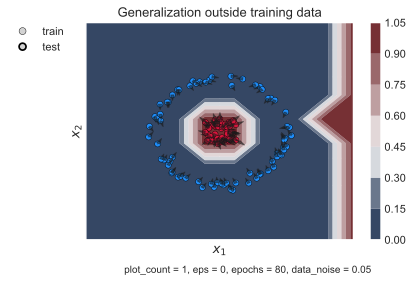

1alingen1_0_0 created


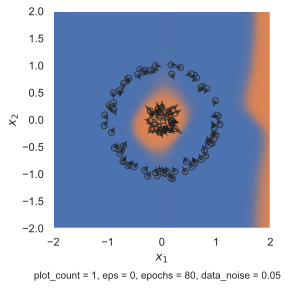

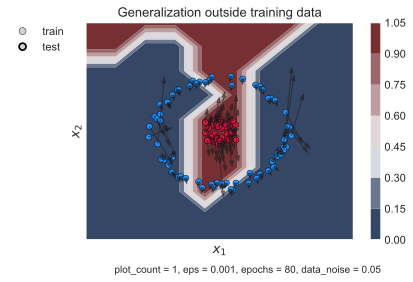

1alingen2_0p001_0 created


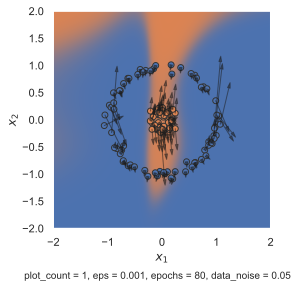

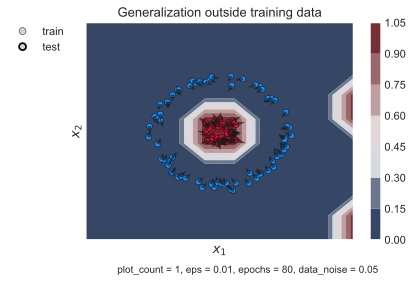

1alingen3_0p01_0 created


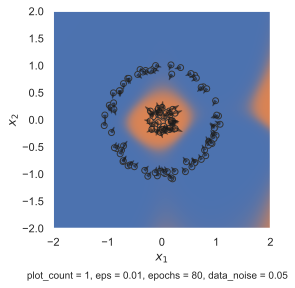

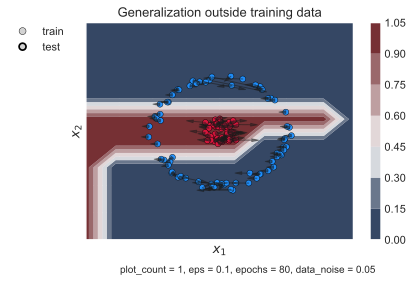

1alingen4_0p1_0 created


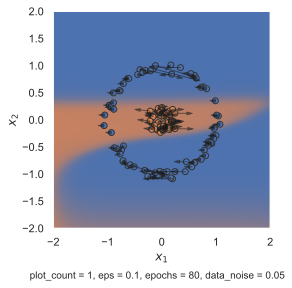

In [10]:
#MODEL INITIALIZITAION AND TRAINING

sort_num = 1

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(dataloader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)
        footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, data_noise)
        plt_classifier(eps_node,  data_line, test, num_steps=10, trainer = trainer_eps_node, footnote = footnote, save_fig = '{}'.format(fig_name_plot) +'.png') 
        print('{} created'.format(fig_name_plot))

        for x_batch, y_batch in dataloader_viz:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10* grad
    
            footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, data_noise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote)
            plt.show()
            break
        sort_num += 1

In [11]:
import torch.utils.data as data

class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1, shift = torch.zeros(2, dtype = torch.float32)):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.shift = shift
        self.generate_continuous_xor()
        

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.shift
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label



dataset = XORDataset(size=200, std = 0.2)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

shift = torch.Tensor([-.5, -.5])
train_dataset = XORDataset(size=2500, std = 0.2, shift = shift)
train_xor_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = XORDataset(size=500, std = 0.2, shift = shift)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_xor_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

Size of dataset: 200
Data point 0: (tensor([ 0.1339, -0.1073]), tensor(0))


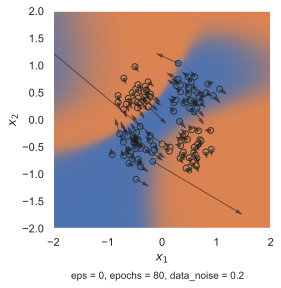

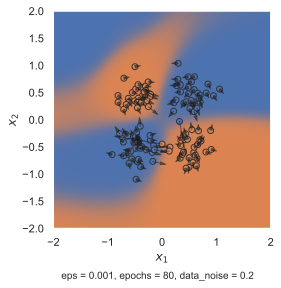

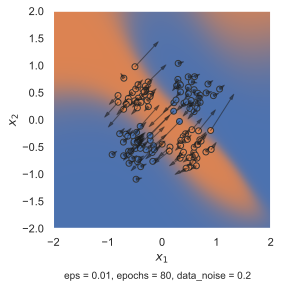

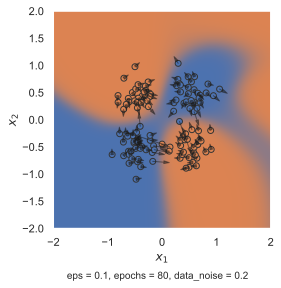

In [12]:
sort_num = 1

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(train_xor_loader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)
        
        
       

        for x_batch, y_batch in test_xor_loader:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10* grad
    
            footnote = 'eps = {}, epochs = {}, data_noise = {}'.format( eps, num_epochs, 0.2)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote)
            plt.show()
            break
        sort_num += 1

In [ ]:
epsilons = [0.001]

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    
    trainer_eps_node.train(dataloader, plot_steps)

    

    for x_batch, y_batch in dataloader_viz:
        trajectory_gif(eps_node, x_batch, y_batch, timesteps=num_steps, filename = filename_s +'.gif')
        break
    sort_num += 1


